In [ ]:
!pip install tensorflow
!pip install pandas
!pip install numpy

In [58]:
'''
Copyright 2020 Ryan (Mohammad) Solgi
Permission is hereby granted, free of charge, to any person obtaining a copy of 
this software and associated documentation files (the "Software"), to deal in 
the Software without restriction, including without limitation the rights to use, 
copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the 
Software, and to permit persons to whom the Software is furnished to do so, 
subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR 
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, 
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL 
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER 
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, 
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE 
SOFTWARE.
'''

###############################################################################
###############################################################################
###############################################################################

import numpy as np
import sys
import time
from func_timeout import func_timeout, FunctionTimedOut
import matplotlib.pyplot as plt

###############################################################################
###############################################################################
###############################################################################

class geneticalgorithm():
    
    '''  Genetic Algorithm (Elitist version) for Python
    
    An implementation of elitist genetic algorithm for solving problems with
    continuous, integers, or mixed variables.
    
    
    
    Implementation and output:
        
        methods:
                run(): implements the genetic algorithm
                
        outputs:
                output_dict:  a dictionary including the best set of variables
            found and the value of the given function associated to it.
            {'variable': , 'function': }
            
                report: a list including the record of the progress of the
                algorithm over iterations
    '''
    #############################################################
    def __init__(self, function, dimension, variable_type='bool', \
                 variable_boundaries=None,\
                 variable_type_mixed=None, \
                 function_timeout=10,\
                 algorithm_parameters={'max_num_iteration': None,\
                                       'population_size':100,\
                                       'mutation_probability':0.1,\
                                       'elit_ratio': 0.01,\
                                       'crossover_probability': 0.5,\
                                       'parents_portion': 0.3,\
                                       'crossover_type':'uniform',\
                                       'max_iteration_without_improv':None},\
                     convergence_curve=True,\
                         progress_bar=True):


        '''
        @param function <Callable> - the given objective function to be minimized
        NOTE: This implementation minimizes the given objective function. 
        (For maximization multiply function by a negative sign: the absolute 
        value of the output would be the actual objective function)
        
        @param dimension <integer> - the number of decision variables
        
        @param variable_type <string> - 'bool' if all variables are Boolean; 
        'int' if all variables are integer; and 'real' if all variables are
        real value or continuous (for mixed type see @param variable_type_mixed)
        
        @param variable_boundaries <numpy array/None> - Default None; leave it 
        None if variable_type is 'bool'; otherwise provide an array of tuples 
        of length two as boundaries for each variable; 
        the length of the array must be equal dimension. For example, 
        np.array([0,100],[0,200]) determines lower boundary 0 and upper boundary 100 for first 
        and upper boundary 200 for second variable where dimension is 2.
        
        @param variable_type_mixed <numpy array/None> - Default None; leave it 
        None if all variables have the same type; otherwise this can be used to
        specify the type of each variable separately. For example if the first 
        variable is integer but the second one is real the input is: 
        np.array(['int'],['real']). NOTE: it does not accept 'bool'. If variable
        type is Boolean use 'int' and provide a boundary as [0,1] 
        in variable_boundaries. Also if variable_type_mixed is applied, 
        variable_boundaries has to be defined.
        
        @param function_timeout <float> - if the given function does not provide 
        output before function_timeout (unit is seconds) the algorithm raise error.
        For example, when there is an infinite loop in the given function. 
        
        @param algorithm_parameters:
            @ max_num_iteration <int> - stoping criteria of the genetic algorithm (GA)
            @ population_size <int> 
            @ mutation_probability <float in [0,1]>
            @ elit_ration <float in [0,1]>
            @ crossover_probability <float in [0,1]>
            @ parents_portion <float in [0,1]>
            @ crossover_type <string> - Default is 'uniform'; 'one_point' or 
            'two_point' are other options
            @ max_iteration_without_improv <int> - maximum number of 
            successive iterations without improvement. If None it is ineffective
        
        @param convergence_curve <True/False> - Plot the convergence curve or not
        Default is True.
        @progress_bar <True/False> - Show progress bar or not. Default is True.
        
        for more details and examples of implementation please visit:
            https://github.com/rmsolgi/geneticalgorithm
  
        '''
        self.__name__=geneticalgorithm
        #############################################################
        # input function
        assert (callable(function)),"function must be callable"     
        
        self.f=function
        #############################################################
        #dimension
        
        self.dim=int(dimension)
        
        #############################################################
        # input variable type
        
        assert(variable_type=='bool' or variable_type=='int' or\
               variable_type=='real'), \
               "\n variable_type must be 'bool', 'int', or 'real'"
       #############################################################
        # input variables' type (MIXED)     

        if variable_type_mixed is None:
            
            if variable_type=='real': 
                self.var_type=np.array([['real']]*self.dim)
            else:
                self.var_type=np.array([['int']]*self.dim)            

 
        else:
            assert (type(variable_type_mixed).__module__=='numpy'),\
            "\n variable_type must be numpy array"  
            assert (len(variable_type_mixed) == self.dim), \
            "\n variable_type must have a length equal dimension."       

            for i in variable_type_mixed:
                assert (i=='real' or i=='int'),\
                "\n variable_type_mixed is either 'int' or 'real' "+\
                "ex:['int','real','real']"+\
                "\n for 'boolean' use 'int' and specify boundary as [0,1]"
                

            self.var_type=variable_type_mixed
        #############################################################
        # input variables' boundaries 

            
        if variable_type!='bool' or type(variable_type_mixed).__module__=='numpy':
                       
            assert (type(variable_boundaries).__module__=='numpy'),\
            "\n variable_boundaries must be numpy array"
        
            assert (len(variable_boundaries)==self.dim),\
            "\n variable_boundaries must have a length equal dimension"        
        
        
            for i in variable_boundaries:
                assert (len(i) == 2), \
                "\n boundary for each variable must be a tuple of length two." 
                assert(i[0]<=i[1]),\
                "\n lower_boundaries must be smaller than upper_boundaries [lower,upper]"
            self.var_bound=variable_boundaries
        else:
            self.var_bound=np.array([[0,1]]*self.dim)
 
        ############################################################# 
        #Timeout
        self.funtimeout=float(function_timeout)
        ############################################################# 
        #convergence_curve
        if convergence_curve==True:
            self.convergence_curve=True
        else:
            self.convergence_curve=False
        ############################################################# 
        #progress_bar
        if progress_bar==True:
            self.progress_bar=True
        else:
            self.progress_bar=False
        ############################################################# 
        ############################################################# 
        # input algorithm's parameters
        
        self.param=algorithm_parameters
        
        self.pop_s=int(self.param['population_size'])
        
        assert (self.param['parents_portion']<=1\
                and self.param['parents_portion']>=0),\
        "parents_portion must be in range [0,1]" 
        
        self.par_s=int(self.param['parents_portion']*self.pop_s)
        trl=self.pop_s-self.par_s
        if trl % 2 != 0:
            self.par_s+=1
               
        self.prob_mut=self.param['mutation_probability']
        
        assert (self.prob_mut<=1 and self.prob_mut>=0), \
        "mutation_probability must be in range [0,1]"
        
        
        self.prob_cross=self.param['crossover_probability']
        assert (self.prob_cross<=1 and self.prob_cross>=0), \
        "mutation_probability must be in range [0,1]"
        
        assert (self.param['elit_ratio']<=1 and self.param['elit_ratio']>=0),\
        "elit_ratio must be in range [0,1]"                
        
        trl=self.pop_s*self.param['elit_ratio']
        if trl<1 and self.param['elit_ratio']>0:
            self.num_elit=1
        else:
            self.num_elit=int(trl)
            
        assert(self.par_s>=self.num_elit), \
        "\n number of parents must be greater than number of elits"
        
        if self.param['max_num_iteration']==None:
            self.iterate=0
            for i in range (0,self.dim):
                if self.var_type[i]=='int':
                    self.iterate+=(self.var_bound[i][1]-self.var_bound[i][0])*self.dim*(100/self.pop_s)
                else:
                    self.iterate+=(self.var_bound[i][1]-self.var_bound[i][0])*50*(100/self.pop_s)
            self.iterate=int(self.iterate)
            if (self.iterate*self.pop_s)>10000000:
                self.iterate=10000000/self.pop_s
        else:
            self.iterate=int(self.param['max_num_iteration'])
        
        self.c_type=self.param['crossover_type']
        assert (self.c_type=='uniform' or self.c_type=='one_point' or\
                self.c_type=='two_point'),\
        "\n crossover_type must 'uniform', 'one_point', or 'two_point' Enter string" 
        
        
        self.stop_mniwi=False
        if self.param['max_iteration_without_improv']==None:
            self.mniwi=self.iterate+1
        else: 
            self.mniwi=int(self.param['max_iteration_without_improv'])

        
        ############################################################# 
    def run(self):
        
        
        ############################################################# 
        # Initial Population
        
        self.integers=np.where(self.var_type=='int')
        self.reals=np.where(self.var_type=='real')
        
        
        
        pop=np.array([np.zeros(self.dim+1)]*self.pop_s)
        solo=np.zeros(self.dim+1)
        var=np.zeros(self.dim)       
        
        for p in range(0,self.pop_s):
         
            for i in self.integers[0]:
                if(i==2):
                    o = [0, 1, 2]
                    o1 = np.random.choice(o)
                    if(o1 == 0):
                        var[2] = 1
                        solo[2]=var[2].copy()
                    else:
                        var[2] = 0
                        solo[2]=var[2].copy()
                    if(o1 == 1):
                        var[3] = 1
                        solo[3]=var[3].copy()
                    else:
                        var[3] = 0
                        solo[3]=var[3].copy()
                    if(o1 == 2):
                        var[4] = 1
                        solo[4]=var[4].copy()
                    else:
                        var[4] = 0
                        solo[4]=var[4].copy()
                    continue
                if(i==3 or i==4):
                    continue
                if(i==5):
                    o = [0, 1]
                    o1 = np.random.choice(o)
                    if(o1 == 0):
                        var[5] = 1
                        solo[5]=var[5].copy()
                    else:
                        var[5] = 0
                        solo[5]=var[5].copy()
                    if(o1 == 1):
                        var[6] = 1
                        solo[6]=var[6].copy()
                    else:
                        var[6] = 0
                        solo[6]=var[6].copy()
                    continue
                if(i==6):
                    continue
                if(i==7):
                    o = [0, 1, 2]
                    o1 = np.random.choice(o)
                    if(o1 == 0):
                        var[7] = 1
                        solo[7]=var[7].copy()
                    else:
                        var[7] = 0
                        solo[7]=var[7].copy()
                    if(o1 == 1):
                        var[8] = 1
                        solo[8]=var[8].copy()
                    else:
                        var[8] = 0
                        solo[8]=var[8].copy()
                    if(o1 == 2):
                        var[9] = 1
                        solo[9]=var[9].copy()
                    else:
                        var[9] = 0
                        solo[9]=var[9].copy()
                    continue
                if(i==8 or i==9):
                    continue

                var[i]=np.random.randint(self.var_bound[i][0],\
                        self.var_bound[i][1]+1)  
                solo[i]=var[i].copy()
            for i in self.reals[0]:
                var[i]=self.var_bound[i][0]+np.random.random()*\
                (self.var_bound[i][1]-self.var_bound[i][0])    
                solo[i]=var[i].copy()


            obj=self.sim(var)            
            solo[self.dim]=obj
            pop[p]=solo.copy()

        #############################################################

        #############################################################
        # Report
        self.report=[]
        self.test_obj=obj
        self.best_variable=var.copy()
        self.best_function=obj
        ##############################################################   
                        
        t=1
        counter=0
        while t<=self.iterate:
            
            if self.progress_bar==True:
                self.progress(t,self.iterate,status="GA is running...")
            #############################################################
            #Sort
            pop = pop[pop[:,self.dim].argsort()]

                
            
            if (pop[0,self.dim]<self.best_function and (pop[0,2]+pop[0, 3]+pop[0, 4]==1 and pop[0, 5]+pop[0, 6]==1 and pop[0, 7]+pop[0, 8]+pop[0, 9]==1)):
                counter=0
                self.best_function=pop[0,self.dim].copy()
                self.best_variable=pop[0,: self.dim].copy()
            else:
                counter+=1
            #############################################################
            # Report

            self.report.append(pop[0,self.dim])
    
            ##############################################################         
            # Normalizing objective function 
            
            normobj=np.zeros(self.pop_s)
            
            minobj=pop[0,self.dim]
            if minobj<0:
                normobj=pop[:,self.dim]+abs(minobj)
                
            else:
                normobj=pop[:,self.dim].copy()
    
            maxnorm=np.amax(normobj)
            normobj=maxnorm-normobj+1

            #############################################################        
            # Calculate probability
            
            sum_normobj=np.sum(normobj)
            prob=np.zeros(self.pop_s)
            prob=normobj/sum_normobj
            cumprob=np.cumsum(prob)
  
            #############################################################        
            # Select parents
            par=np.array([np.zeros(self.dim+1)]*self.par_s)
            
            for k in range(0,self.num_elit):
                par[k]=pop[k].copy()
            for k in range(self.num_elit,self.par_s):
                index=np.searchsorted(cumprob,np.random.random())
                par[k]=pop[index].copy()
                
            ef_par_list=np.array([False]*self.par_s)
            par_count=0
            while par_count==0:
                for k in range(0,self.par_s):
                    if np.random.random()<=self.prob_cross:
                        ef_par_list[k]=True
                        par_count+=1
                 
            ef_par=par[ef_par_list].copy()
    
            #############################################################  
            #New generation
            pop=np.array([np.zeros(self.dim+1)]*self.pop_s)
            
            for k in range(0,self.par_s):
                pop[k]=par[k].copy()
                
            for k in range(self.par_s, self.pop_s, 2):
                r1=np.random.randint(0,par_count)
                r2=np.random.randint(0,par_count)
                pvar1=ef_par[r1,: self.dim].copy()
                pvar2=ef_par[r2,: self.dim].copy()
                
                ch=self.cross(pvar1,pvar2,self.c_type)
                ch1=ch[0].copy()
                ch2=ch[1].copy()
                
                ch1=self.mut(ch1)
                ch2=self.mutmidle(ch2,pvar1,pvar2)               
                solo[: self.dim]=ch1.copy()                
                obj=self.sim(ch1)
                solo[self.dim]=obj
                pop[k]=solo.copy()                
                solo[: self.dim]=ch2.copy()                
                obj=self.sim(ch2)               
                solo[self.dim]=obj
                pop[k+1]=solo.copy()
        #############################################################       
            t+=1
            if counter > self.mniwi:
                pop = pop[pop[:,self.dim].argsort()]
                if (pop[0,self.dim]>=self.best_function):
                    t=self.iterate
                    if self.progress_bar==True:
                        self.progress(t,self.iterate,status="GA is running...")
                    time.sleep(2)
                    t+=1
                    self.stop_mniwi=True
                
        #############################################################
        #Sort
        pop = pop[pop[:,self.dim].argsort()]
        
        if (pop[0,self.dim]<self.best_function and (pop[0, 2]+pop[0, 3]+pop[0, 4]==1 and pop[0, 5]+pop[0, 6]==1 and pop[0, 7]+pop[0, 8]+pop[0, 9]==1)):
                
            self.best_function=pop[0,self.dim].copy()
            self.best_variable=pop[0,: self.dim].copy()
        #############################################################
        # Report

        self.report.append(pop[0,self.dim])
        
        
 
        
        self.output_dict={'variable': self.best_variable, 'function':\
                          self.best_function}
        if self.progress_bar==True:
            show=' '*100
            sys.stdout.write('\r%s' % (show))
        sys.stdout.write('\r The best solution found:\n %s' % (self.best_variable))
        sys.stdout.write('\n\n Objective function:\n %s\n' % (self.best_function))
        sys.stdout.flush() 
        re=np.array(self.report)
        if self.convergence_curve==True:
            plt.plot(re)
            plt.xlabel('Iteration')
            plt.ylabel('Objective function')
            plt.title('Genetic Algorithm')
            plt.show()
        
        if self.stop_mniwi==True:
            sys.stdout.write('\nWarning: GA is terminated due to the'+\
                             ' maximum number of iterations without improvement was met!')
##############################################################################         
##############################################################################         
    def cross(self,x,y,c_type):
         
        ofs1=x.copy()
        ofs2=y.copy()
        

        if c_type=='one_point':
            ran=np.random.randint(0,self.dim)
            for i in range(0,ran):
                ofs1[i]=y[i].copy()
                ofs2[i]=x[i].copy()
  
        if c_type=='two_point':
                
            ran1=np.random.randint(0,self.dim)
            ran2=np.random.randint(ran1,self.dim)
                
            for i in range(ran1,ran2):
                ofs1[i]=y[i].copy()
                ofs2[i]=x[i].copy()
            
        if c_type=='uniform':
                
            for i in range(0, self.dim):
                ran=np.random.random()
                if ran <0.5:
                    ofs1[i]=y[i].copy()
                    ofs2[i]=x[i].copy() 
                   
        return np.array([ofs1,ofs2])
###############################################################################  
    
    def mut(self,x):
        
        for i in self.integers[0]:
            ran=np.random.random()
            if ran < self.prob_mut:
                
                x[i]=np.random.randint(self.var_bound[i][0],\
                 self.var_bound[i][1]+1) 
                    
        

        for i in self.reals[0]:                
            ran=np.random.random()
            if ran < self.prob_mut:   

               x[i]=self.var_bound[i][0]+np.random.random()*\
                (self.var_bound[i][1]-self.var_bound[i][0])    
            
        return x
###############################################################################
    def mutmidle(self, x, p1, p2):
        for i in self.integers[0]:
            ran=np.random.random()
            if ran < self.prob_mut:
                if p1[i]<p2[i]:
                    x[i]=np.random.randint(p1[i],p2[i])
                elif p1[i]>p2[i]:
                    x[i]=np.random.randint(p2[i],p1[i])
                else:
                    x[i]=np.random.randint(self.var_bound[i][0],\
                 self.var_bound[i][1]+1)
                        
        for i in self.reals[0]:                
            ran=np.random.random()
            if ran < self.prob_mut:   
                if p1[i]<p2[i]:
                    x[i]=p1[i]+np.random.random()*(p2[i]-p1[i])  
                elif p1[i]>p2[i]:
                    x[i]=p2[i]+np.random.random()*(p1[i]-p2[i])
                else:
                    x[i]=self.var_bound[i][0]+np.random.random()*\
                (self.var_bound[i][1]-self.var_bound[i][0]) 
        return x
###############################################################################     
    def evaluate(self):
        return self.f(self.temp)
###############################################################################    
    def sim(self,X):
        self.temp=X.copy()
        obj=None
        try:
            obj=func_timeout(self.funtimeout,self.evaluate)
        except FunctionTimedOut:
            print("given function is not applicable")
        assert (obj!=None), "After "+str(self.funtimeout)+" seconds delay "+\
                "func_timeout: the given function does not provide any output"
        return obj

###############################################################################
    def progress(self, count, total, status=''):
        bar_len = 50
        filled_len = int(round(bar_len * count / float(total)))

        percents = round(100.0 * count / float(total), 1)
        bar = '|' * filled_len + '_' * (bar_len - filled_len)

        sys.stdout.write('\r%s %s%s %s' % (bar, percents, '%', status))
        sys.stdout.flush()     
###############################################################################            
###############################################################################

In [63]:
from geneticalgorithm import geneticalgorithm as ga
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import model_from_json
from keras import backend as k

json_file = open('/content/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/model.h5")

def GA(population_size, mutation_probability, crossover_probability, parents_portion):
  def fitnessfunction(x):
      x= np.reshape(x, ( 1 ,x.shape[0]))
      output = loaded_model.predict(x)
      output = - output
      return output

  varbound=np.array([[5, 8], [60, 60.1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1]])
#  varbound=np.array([[5, 8], [60, 60.1], [0,2], [0,1], [0,2]])
#  vartype=np.array([['int'],['int'],['int'],['int'],['int']])
  vartype=np.array([['int'],['int'],['int'],['int'],['int'],['int'],['int'],['int'],['int'],['int']])

  algorithm_param = {'max_num_iteration': None,\
                     'population_size': population_size,\
                    'crossover_probability':crossover_probability,\
                    'mutation_probability':mutation_probability,\
                    'elit_ratio': 0.01,\
                    'crossover_probability':crossover_probability,\
                    'parents_portion':parents_portion,\
                    'crossover_type':'uniform',\
                    'max_iteration_without_improv':None}

  model=geneticalgorithm(function=fitnessfunction,dimension=10,variable_type_mixed=vartype,variable_boundaries=varbound,algorithm_parameters=algorithm_param)

  model.run()

In [64]:
population_size = [100]
mutation_probability = [0.1]
crossover_probability = [0.5]
parents_portion = [0.3]

population_size: 100
mutation_probability: 0.1
crossover_probability: 0.5
parents_portion: 0.3
 The best solution found:
 [ 5. 60.  0.  0.  1.  0.  1.  0.  1.  0.]

 Objective function:
 -73.95179748535156


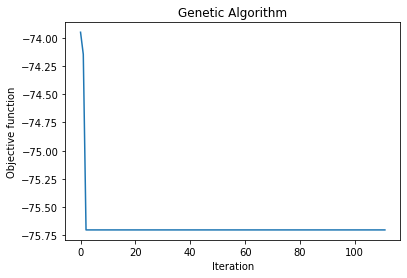

In [65]:
for i in population_size:
  for j in mutation_probability:
    for k in crossover_probability:
      for l in parents_portion:
        print("population_size: %r"%i)
        print("mutation_probability: %r"%j)
        print("crossover_probability: %r"%k)
        print("parents_portion: %r"%l)
        GA(i, j, k, l)

In [37]:
#x = [8, 1, 0, 2, 49.91]
x = [5, 60, 0, 0, 1, 0, 1, 0, 1, 0]
#x = [8, 49.91, 0, 1, 0, 1, 0, 0, 0, 1]
x =np.array(x)
x= np.reshape(x, ( 1 ,x.shape[0]))
output = loaded_model.predict(x)
print(output[0][0])

73.9518
